In [27]:
import intro

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from kneed import KneeLocator

pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
# segmentation of ambient temperature
tq = np.quantile(intro.signals.Amb_Temp_Avg, [0, 0.25, 0.5, 0.75, 1])
print(tq)

[ 4. 16. 19. 24. 41.]


In [407]:
# select turbine for testing
test = intro.signals_T09

In [409]:
# failures of selected turbine
test[test.Failure == 1]

,Turbine_ID,Timestamp,Gen_RPM_Avg,Gen_Bear_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Avg,Amb_WindSpeed_Avg,Amb_Temp_Avg,Prod_LatestAvg_TotActPwr,Grd_Prod_Pwr_Avg,Gen_Bear2_Temp_Avg,Component,Remarks,Failure,Wind_Segment_Code,Prior_Failure_2h
22790,T09,2016-06-07 17:00:00+00:00,1609.3,99.0,51,57,70,42,14.2,13.0,29,302488.0,1809.5,79,GENERATOR_BEARING,High tempemperature generator bearing,1,11,1
33697,T09,2016-08-22 18:20:00+00:00,1681.8,98.0,48,59,70,45,14.8,14.3,29,332638.0,1995.6,75,GENERATOR_BEARING,High temperature generator bearing,1,11,1
40632,T09,2016-10-11 08:10:00+00:00,184.1,30.0,50,35,36,27,1.5,2.6,18,-1170.0,-7.0,31,GEARBOX,Gearbox repaired,1,0,1
41490,T09,2016-10-17 09:20:00+00:00,598.9,28.0,48,37,40,26,5.2,3.6,20,714.0,4.3,28,GENERATOR_BEARING,Generator bearings replaced,1,0,1
55876,T09,2017-01-25 13:00:00+00:00,176.1,23.0,33,24,30,23,1.3,4.0,15,-1327.0,-8.0,19,GENERATOR_BEARING,Generator bearings replaced,1,1,1


In [410]:
def prior_failure_column(df, hours=2):
    """
    Input:
    df = turbine signals data frame
    hours = time prior failure
    
    This function adds prior failure column to data frame for specific time.
    """
    failure_times = df[df.Failure == 1].Timestamp
    N = len(failure_times)
    for i in range(N):
        df["Prior_Failure_" + str(hours) + "h_date" + str(i)] = df.Timestamp.apply(lambda x: 1 if failure_times.iloc[i] - x <= timedelta(hours=hours) and x <= failure_times.iloc[i] else 0)
    df["Prior_Failure_" + str(hours) + "h"] = np.sum(df.iloc[:, -N:], axis=1)
    df["Prior_Failure_" + str(hours) + "h"] = df["Prior_Failure_" + str(hours) + "h"].apply(lambda x: 1 if x > 0 else 0)
    for i in range(N):
        df.drop(columns=["Prior_Failure_" + str(hours) + "h_date" + str(i)], inplace=True)
        
prior_failure_column(test)

In [411]:
def plot_rotor_power(turbine, hours=2):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(turbine.Prod_LatestAvg_TotActPwr, turbine.Rtr_RPM_Avg, marker="+", s=10, alpha=0.2)
    condition = turbine["Prior_Failure_" + str(hours) + "h"] == 1
    ax.scatter(turbine[condition].Prod_LatestAvg_TotActPwr, turbine[condition].Rtr_RPM_Avg, color="orange", marker="+")
    ax.set_xlabel("Active Power [Wh]")
    ax.set_ylabel("Rotor RPM")
    ax.set_title("Turbine " + str(turbine.Turbine_ID.iloc[0]))
    legend_elements = [Line2D([0], [0], marker='+', color='C0', label='Normal', lw=0, markersize=10),
                  Line2D([0], [0], marker='+', color='orange', label='Prior Failure', lw=0, markersize=10)]
    ax.legend(handles=legend_elements)
    #ax.set_ylim(7, 18)
    plt.savefig("../img/rotor_power")

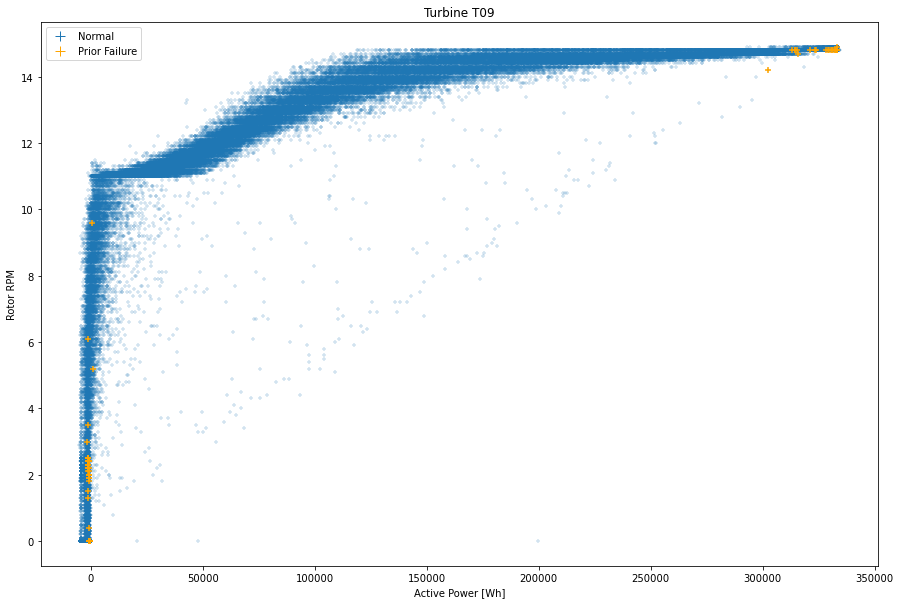

In [412]:
plot_rotor_power(test)

In [413]:
# select temp. seg. (0-3); tq = [ 4. 16. 19. 24. 41.] and wind segment code (see intro.py)
tseg = 3

test = test[(test.Wind_Segment_Code == 11) & (test.Amb_Temp_Avg >= tq[tseg]) & (test.Amb_Temp_Avg < tq[tseg + 1])]

In [414]:
# types of failures (filtered)
test.Component.unique()

array([nan, 'GENERATOR_BEARING'], dtype=object)

The inertia for 2 clusters is 43415.30145078433
The inertia for 3 clusters is 27272.23549494788
The inertia for 4 clusters is 22947.981296348564
The inertia for 5 clusters is 20069.036832903646
The inertia for 6 clusters is 17375.996294322467
The inertia for 7 clusters is 15328.738411744453
The inertia for 8 clusters is 14202.557030614345
The inertia for 9 clusters is 13117.983372496068
The inertia for 10 clusters is 12378.99845810735

knee/elbow = 4


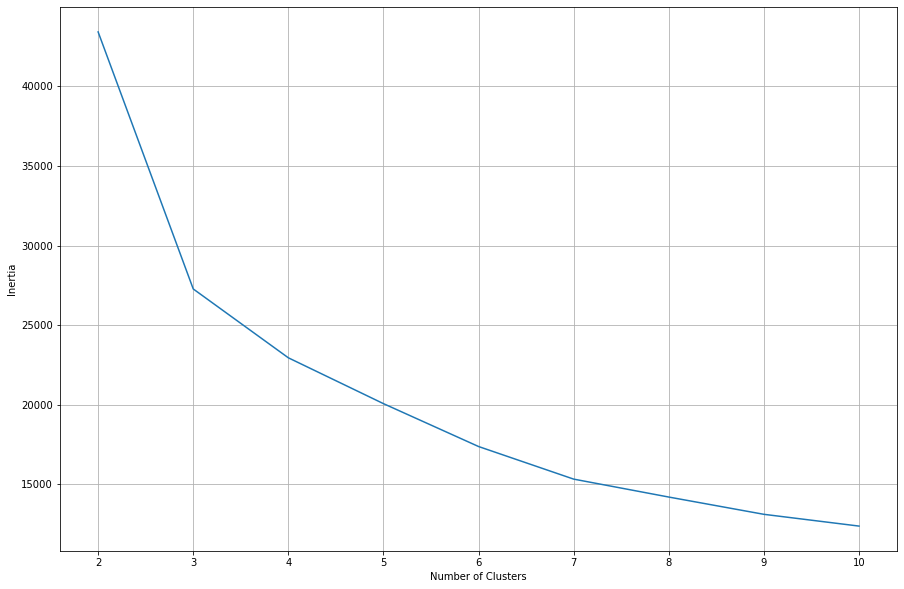

In [415]:
# selected features (no wind and temp because we filter it out)
f = ["Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg",
     "Gen_Bear_Temp_Avg", "Gen_Bear2_Temp_Avg", "Hyd_Oil_Temp_Avg", "Gear_Oil_Temp_Avg"]

X = test.loc[:, f]

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

n_clusters = range(2, 11)
inertia = []

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500)
    kmeans.fit(X_std)
    i = kmeans.inertia_
    inertia.append(i)
    print("The inertia for " + str(k) + " clusters is " + str(i))

# inertia plot to help determine "best" number of clusters
fig, ax = plt.subplots(figsize=(15, 10))
x = np.arange(len(n_clusters))
ax.plot(x, inertia)
ax.set_xticks(x)
ax.set_xticklabels(n_clusters)
ax.grid()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia")

kn = KneeLocator(list(n_clusters), inertia, curve='convex', direction='decreasing')
print("\nknee/elbow = " + str(kn.knee))

PCA Loading Scores:

Gear_Bear_Temp_Avg    0.456981
Gear_Oil_Temp_Avg     0.434357
Gen_Bear_Temp_Avg     0.372054
Gen_Bear2_Temp_Avg    0.370636
Gen_RPM_Avg           0.335139
Rtr_RPM_Avg           0.334267
Nac_Temp_Avg          0.290525
Hyd_Oil_Temp_Avg      0.135090
dtype: float64


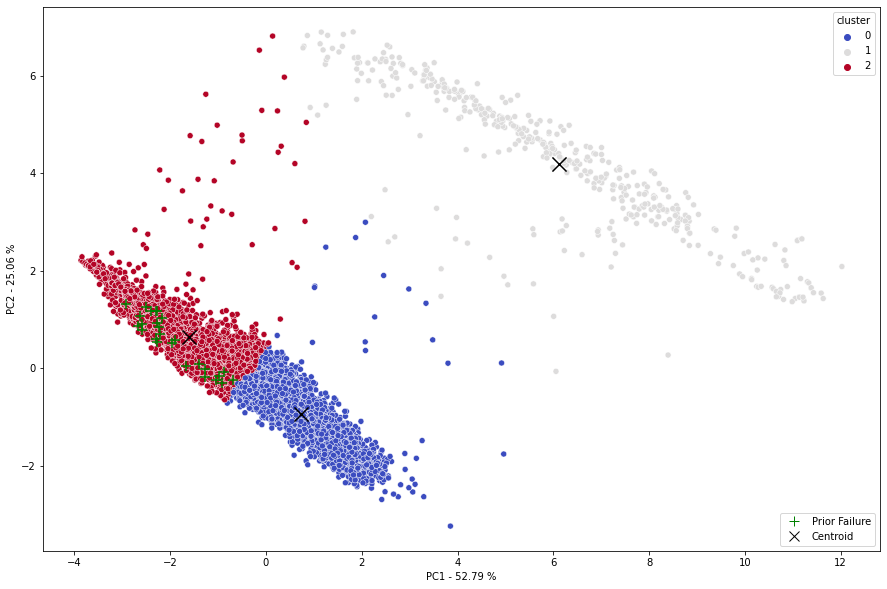

In [416]:
# n_clusters = kn.knee OR select other (ex. number of failure types)
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=100, max_iter=1000, random_state=0)
kmeans.fit(X_std)
clusters = kmeans.predict(X_std)

pca = PCA(n_components=2)
X_reduced = pd.DataFrame(pca.fit_transform(X_std), columns=["PC1", "PC2"])
X_reduced["cluster"] = clusters
X_reduced["prior_failure"] = test["Prior_Failure_2h"].reset_index(drop=True)
X_reduced["wind_seg"] = test["Wind_Segment_Code"].reset_index(drop=True)

reduced_centers = pca.transform(kmeans.cluster_centers_)
exp_var = np.round(pca.explained_variance_ratio_ * 100, 2)

loading_scores = pd.Series(pca.components_[0], index=f)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print("PCA Loading Scores:\n")
print(sorted_loading_scores)

fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(x="PC1", y="PC2", data=X_reduced, hue="cluster", ax=ax, palette="coolwarm")

ax.scatter(X_reduced[X_reduced.prior_failure == 1]["PC1"], X_reduced[X_reduced.prior_failure == 1]["PC2"],
           color="green", marker="+", s=100)

ax.scatter(reduced_centers[:, 0], reduced_centers[:, 1], color="black", marker="x", s=200)

ax.set_xlabel("PC1 - " + str(exp_var[0]) + " %")
ax.set_ylabel("PC2 - " + str(exp_var[1]) + " %")

legend_elements = [Line2D([0], [0], marker='+', color='green', label='Prior Failure', lw=0, markersize=10),
                  Line2D([0], [0], marker='x', color='black', label='Centroid', lw=0, markersize=10)]

leg1 = ax.legend(title="cluster", loc="upper right")
leg2 = ax.legend(handles=legend_elements, loc="lower right")
ax.add_artist(leg1)

plt.savefig("../img/pca_failure")

In [417]:
# add cluster column
test["cluster"] = clusters

In [418]:
test[test.cluster == 0].Component.unique()

array([nan], dtype=object)

In [419]:
test[test.cluster == 1].Component.unique()

array([nan], dtype=object)

In [420]:
test[test.cluster == 2].Component.unique()

array([nan, 'GENERATOR_BEARING'], dtype=object)

In [396]:
#test[test.cluster == 3].Component.unique()

array([nan], dtype=object)

In [303]:
#test[test.cluster == 4].Component.unique()

array([nan, 'GENERATOR_BEARING'], dtype=object)

In [322]:
#test[(test.cluster == 3) & (test.Prior_Failure_2h == 1)]

,Turbine_ID,Timestamp,Gen_RPM_Avg,Gen_Bear_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Avg,Amb_WindSpeed_Avg,Amb_Temp_Avg,Prod_LatestAvg_TotActPwr,Grd_Prod_Pwr_Avg,Gen_Bear2_Temp_Avg,Component,Remarks,Failure,Wind_Segment_Code,Prior_Failure_2h,cluster
33807,T07,2016-08-23 00:40:00+00:00,1622.9,35.0,44,50,52,33,14.4,9.1,26,211609.0,1269.1,47,NaN,NaN,0,11,1,3
33808,T07,2016-08-23 00:50:00+00:00,1663.4,39.0,45,52,56,33,14.7,10.3,26,266877.0,1601.8,54,NaN,NaN,0,11,1,3
33809,T07,2016-08-23 01:00:00+00:00,1665.8,43.0,46,54,58,32,14.8,10.4,25,277985.0,1670.9,59,NaN,NaN,0,11,1,3
33810,T07,2016-08-23 01:10:00+00:00,1673.1,46.0,47,56,60,32,14.8,10.8,25,303221.0,1820.2,63,NaN,NaN,0,11,1,3
33817,T07,2016-08-23 02:20:00+00:00,1672.4,64.0,42,58,64,35,14.8,11.2,25,313799.0,1882.2,75,TRANSFORMER,High temperature transformer. Transformer refr...,1,11,1,3


In [421]:
test[test.cluster == 0].describe().loc["mean", :]

Gen_RPM_Avg                   1663.779884
Gen_Bear_Temp_Avg               68.180397
Hyd_Oil_Temp_Avg                50.444519
Gear_Oil_Temp_Avg               53.028355
Gear_Bear_Temp_Avg              64.195133
Nac_Temp_Avg                    38.631837
Rtr_RPM_Avg                     14.682675
Amb_WindSpeed_Avg               10.695111
Amb_Temp_Avg                    26.041527
Prod_LatestAvg_TotActPwr    256442.449207
Grd_Prod_Pwr_Avg              1538.737330
Gen_Bear2_Temp_Avg              59.204733
Failure                          0.000000
Wind_Segment_Code               11.000000
Prior_Failure_2h                 0.000000
cluster                          0.000000
Name: mean, dtype: float64

In [422]:
test[test.cluster == 1].describe().loc["mean", :]

Gen_RPM_Avg                   64.548970
Gen_Bear_Temp_Avg             63.302059
Hyd_Oil_Temp_Avg              49.038902
Gear_Oil_Temp_Avg             47.771167
Gear_Bear_Temp_Avg            48.084668
Nac_Temp_Avg                  40.917620
Rtr_RPM_Avg                    0.341419
Amb_WindSpeed_Avg             12.847368
Amb_Temp_Avg                  28.151030
Prod_LatestAvg_TotActPwr    2795.212815
Grd_Prod_Pwr_Avg              13.995652
Gen_Bear2_Temp_Avg            52.599542
Failure                        0.000000
Wind_Segment_Code             11.000000
Prior_Failure_2h               0.000000
cluster                        1.000000
Name: mean, dtype: float64

In [423]:
test[test.cluster == 2].describe().loc["mean", :]

Gen_RPM_Avg                   1665.506332
Gen_Bear_Temp_Avg               85.662772
Hyd_Oil_Temp_Avg                47.878261
Gear_Oil_Temp_Avg               56.344293
Gear_Bear_Temp_Avg              67.985870
Nac_Temp_Avg                    42.619565
Rtr_RPM_Avg                     14.687609
Amb_WindSpeed_Avg               12.880272
Amb_Temp_Avg                    27.467120
Prod_LatestAvg_TotActPwr    302396.635326
Grd_Prod_Pwr_Avg              1814.266060
Gen_Bear2_Temp_Avg              71.871467
Failure                          0.000543
Wind_Segment_Code               11.000000
Prior_Failure_2h                 0.007065
cluster                          2.000000
Name: mean, dtype: float64

In [400]:
#test[test.cluster == 3].describe().loc["mean", :]

Gen_RPM_Avg                  1314.449799
Gen_Bear_Temp_Avg              53.012048
Hyd_Oil_Temp_Avg               34.439759
Gear_Oil_Temp_Avg              52.393574
Gear_Bear_Temp_Avg             58.508032
Nac_Temp_Avg                   29.624498
Rtr_RPM_Avg                    11.640964
Amb_WindSpeed_Avg               5.723293
Amb_Temp_Avg                   21.989960
Prod_LatestAvg_TotActPwr    51975.949799
Grd_Prod_Pwr_Avg              311.787349
Gen_Bear2_Temp_Avg             46.680723
Failure                         0.000000
Wind_Segment_Code               4.000000
Prior_Failure_2h                0.000000
cluster                         3.000000
Name: mean, dtype: float64

In [318]:
#test[test.cluster == 4].describe().loc["mean", :]

Gen_RPM_Avg                  61.256024
Gen_Bear_Temp_Avg            58.512048
Hyd_Oil_Temp_Avg             46.533133
Gear_Oil_Temp_Avg            52.918675
Gear_Bear_Temp_Avg           52.536145
Nac_Temp_Avg                 37.355422
Rtr_RPM_Avg                   0.264759
Amb_WindSpeed_Avg            14.334789
Amb_Temp_Avg                 27.393072
Prod_LatestAvg_TotActPwr    601.397590
Grd_Prod_Pwr_Avg              3.655422
Gen_Bear2_Temp_Avg           52.082831
Failure                       0.001506
Wind_Segment_Code            11.000000
Prior_Failure_2h              0.001506
cluster                       4.000000
Name: mean, dtype: float64